In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from  pandasgui import show
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import cross_val_predict
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

In [2]:
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
train_data = pd.read_csv('../data/airline_passenger_satisfaction.csv')
# primeros_100_registros = train_data.iloc[:100]
# test_data = pd.DataFrame(primeros_100_registros)
primer_registro = train_data.iloc[0]
test_data = pd.DataFrame([primer_registro])

In [3]:
#obtenemos un arreglo con los nombres de las variables segun su tipo
imputer_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in train_data.columns if train_data[cname].dtype == "object"]

In [4]:
imputer = SimpleImputer(strategy='mean' )
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

In [5]:
# completamos valores nulos  en las columnas categoricas con la moda
def fill_null_with_mode(column, train_df, test_df):
    moda = train_df[column].mode().iloc[0]
    train_df[column] = train_df[column].fillna(moda)
    test_df[column] = test_df[column].fillna(moda)

# Aplicar la función de llenado de valores nulos
fill_null_with_mode(categorical_cols, train_data, test_data)

In [6]:
#preparamos los datos para dividirlos
train_data.drop(["Unnamed: 0" ,"id"] , axis = 1 ,inplace = True)
test_data.drop(["Unnamed: 0" ,"id","satisfaction"] , axis = 1 ,inplace = True)
# TODO no estoy seguro si debo elimiar satisfaction de test
X = train_data.drop("satisfaction" , axis =1 )
y = train_data["satisfaction"]

In [7]:
# encoding y escaling

numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print(numerical_cols)
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
print(categorical_cols)
boolean_cols = [cname for cname in X.columns if X[cname].dtype == 'bool']
print(boolean_cols)

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
test_data = ct.transform(test_data)

# Print new shape
print('Training set shape:', X.shape)

['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
['Gender', 'Customer Type', 'Type of Travel', 'Class']
[]
Training set shape: (103904, 24)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [9]:
# Crear el pipeline con los parametros del grid research
# my_pipeline = Pipeline(steps=[
#     ('model', XGBClassifier(**clf_best_params["LGBM"], random_state=0))
# ])
my_pipeline = Pipeline(steps=[
    ('model', RandomForestClassifier(n_estimators=50))
])

# Realizar la validación cruzada y obtener las probabilidades y los scores
proba_predictions = cross_val_predict(my_pipeline, X, y, cv=10, method='predict_proba')
accuracy_scores = cross_val_predict(my_pipeline, X, y, cv=10, method='predict')


KeyboardInterrupt: 

In [10]:
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [ ]:
classifier.predict(test_data)


array(['neutral or dissatisfied'], dtype=object)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
# Calcular promedio de las probabilidades de la clase positiva
preds = proba_predictions[:, 1].mean()

# Calcular promedio del score de precisión
average_accuracy = accuracy_score(y, accuracy_scores)

#Matriz
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcula la precisión
precision = precision_score(y_test, y_pred, average='macro')

# Calcula el recall
recall = recall_score(y_test, y_pred, average='macro')

# Calcula el F1-Score
f1 = f1_score(y_test, y_pred, average='macro')

# Imprimir los resultados
print("Average probability:", preds)
print("Average accuracy:", average_accuracy)
print("Matriz de Confusión:\n", conf_matrix)
print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Average probability: 0.4335321065599013
Average accuracy: 0.9615317985833076
Matriz de Confusión:
 [[11510   266]
 [  579  8426]]
Precisión: 0.96
Recall: 0.96
F1-Score: 0.96


**Average probability**  
Esto nos indica que de la cantidad de clientes satisfechos (satisfied) hay un 43.35% del total general , por lo tanto lo restante serian los que estan como "neutral or dissatisfied".

**Average accuracy**  
Aqui podemos observar que en cuanto a predicciones correctas, es decir que nuestro modelo cuenta con un 96.15% de acertividad en cuanto a las pruebas realizadas.

**Matriz de confusión**  
La matriz de confusión es la variable que nos permite determinar la capacidad del modelo para evitar clasificar incorrectamente las instancias negativas como positivas. A diferencia de la precisión uqe nos da una vision general de la acertividad , la matriz de confusión se utiliza para saber la categorizacion de las predicciones.

En esta métrica nos indica cuantos verdaderos positivos hay (11510) es decir que la mayoria de resultados aqui estan estado "satisfied"; Falsos positivos aqui se puede ver que el modelo interpretó 266 clientes que en realidad estan en estado  "neutral or dissatisfied" pero que el modelo tomó como "satisfied"; En cuanto a 579 , nos indica que el modelo interpreta estos datos como falsos negativos , que quiere decir que en realidad estos clientes estan como "satisfied" pero el modelo los tomó como "neutral or dissatisfied"; por último 8426 que significa que aqui estan los verdaderos negativos , que aqui todos los clientes estan como "neutral or dissatisfied".

**Precisión**  
Esto nos indica que de toda la base de datos el 96% es acertado con respecto a predicciones positivas, a diferencia de ka atriz de confusión , la precisión no tiene en cuenta estos falsos positivos y se centra en la proporción de predicciones positivas correctas en relación con todas las predicciones positivas. 

**Recall**  
El recall responde a la pregunta: "De todos los casos positivos reales, ¿cuántos de ellos el modelo fue capaz de identificar correctamente?". Es una métrica importante en problemas donde la detección de todos los casos positivos es crítica, como en la detección temprana de enfermedades o la identificación de fraudes. En este caso se puede determinar que el 96% de de los casos verdaderos positivos es correctamente identificado por el modelo.

**F1-Score**  
El F1-Score es útil cuando deseamos tener un equilibrio entre la precisión y el recall. Proporciona una puntuación que combina ambas métricas y es útil cuando ninguna de las dos métricas por sí sola es suficiente. En nuestro caso indica que está cerca al 1.0 entonces indica un buen equilibrio entre la precisión y el recall.


In [ ]:
# Obtiene la importancia de las características
importancia_caracteristicas = classifier.feature_importances_

# Puedes imprimir la importancia de cada característica
for i, importancia in enumerate(importancia_caracteristicas):
    print(f'Característica {i}: {importancia}')

Característica 0: 0.03149787842335563
Característica 1: 0.03882065995556317
Característica 2: 0.14928697448731937
Característica 3: 0.01743804911251303
Característica 4: 0.042022437781536796
Característica 5: 0.01720206229602577
Característica 6: 0.012479730567605863
Característica 7: 0.1683011901861943
Característica 8: 0.03173736652305101
Característica 9: 0.056993604835924486
Característica 10: 0.029572908257979723
Característica 11: 0.03843288435845641
Característica 12: 0.02304819967183166
Característica 13: 0.024179327671385246
Característica 14: 0.021097195136850298
Característica 15: 0.02464691374883725
Característica 16: 0.011678908911038462
Característica 17: 0.012384900172400879
Característica 18: 0.004697529262447003
Característica 19: 0.026858851433150605
Característica 20: 0.07907839206865887
Característica 21: 0.080419780869606
Característica 22: 0.053816211025445426
Característica 23: 0.00430804324282285


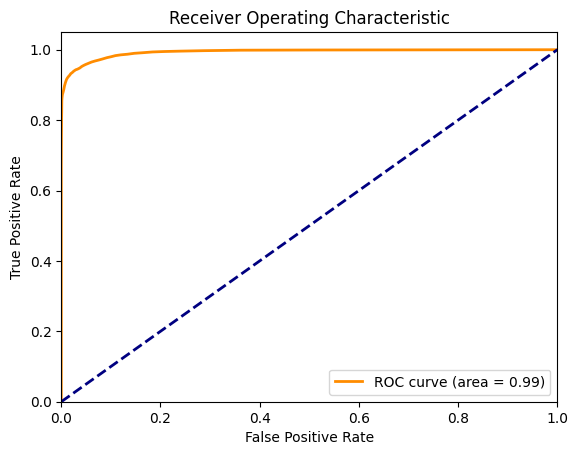

In [ ]:
# Mapea las etiquetas a valores binarios
y_true_binary = [1 if label == "satisfied" else 0 for label in y_test]

# Obtén las probabilidades de predicción del modelo (por ejemplo, un clasificador de bosque aleatorio)
probs = classifier.predict_proba(X_test)  # X_test son las características de prueba

# Calcula la curva ROC especificando pos_label=1
fpr, tpr, umbrales = roc_curve(y_true_binary, probs[:, 1], pos_label=1)

# Calcula el área bajo la curva ROC (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [11]:
train_data.show()

AttributeError: 'DataFrame' object has no attribute 'show'